In [1]:
#モンテカルロ法
import gym
env = gym.make('FrozenLake-v0', is_slippery=False) #進みたい方向に必ず進める前提
env.render()


SFFF
FHFH
FFFH
HFFG


In [71]:
#動的計画法との違い
##あらかじめ決められた報酬ではなく、「ゲームをやってみた結果、もらった報酬」を元に価値計算
##今回の価値は Q(s, a)で表される「行動の価値」
###Gt = r(t+1)+γ*r(t+2)＋・・・各ステップの報酬に割引率をかけたものの合計

# Q(s, a)←Q(s, a)+α（Gt-Q(s, a)） Gt-Q(s, a)実際の報酬と予想の報酬の差　αは学習率
# Qは１ゲーム終了するごとに更新される
import numpy as np
import pandas as pd

class MonteCarlo:
    def __init__(self, env):
        self.env = env
        self.Q = {}
        self.initialize()
        self.reward_log = []
        
    def initialize(self):
        for s in range(self.env.nS):
            self.Q[s] = [0]*self.env.nA
            
    def policy(self,s, epsilon=0.1):
        if np.random.random() < epsilon:
            return np.random.randint(self.env.nA)
        else:
            if sum(self.Q[s])==0: #Q[s]が全て０だった場合に必ず行動が０（左）になるのを防ぐため
                return np.random.randint(self.env.nA)
            else:
                return np.argmax(self.Q[s]) #sのときに最も高い報酬が見込まれる行動
            
    def learn(self, episode_count=1000, gamma=0.9, alpha=0.8):
        for e in range(episode_count):
            self.env.reset()
            s = 0
            done = False
            experience_log = []
            while not done: #GOALかHOLEに進むまで
                #探索（ランダムに行動する）
                #a = np.random.randint(self.env.nA) #０から３までのランダムな数字
                #活用：Q（s, a）から最善の行動をとる
                #探索と活用はトレードオフなので、探索10％活用９０％とする
                a = self.policy(s)
                
                next_s, reward, done, _ = self.env.step(a) #遷移確率を使わない
                experience_log.append({'state':s, 'action':a, 'reward':reward})
                s = next_s
            else:
                self.reward_log.append(reward)
                
            for t, experience in enumerate(experience_log):
                G = 0 #割引現在価値
                i = 0
                for j in range(t, len(experience_log)):
                    G+= (gamma**i)* experience_log[j]['reward']
                    i+=1
                s = experience['state']
                a = experience['action']
                self.Q[s][a] += alpha * (G - self.Q[s][a])
        return self.Q
    
    def show_reward(self, interval=50):
        average_rewards = {}
        for e in range(0,len(self.reward_log), interval):
            average_rewards[e] = np.mean(self.reward_log[e:e+interval])
            
        return pd.Series(average_rewards)
#      def dict_to_grid(self, V):
#         grid = []
#         for i in range(self.env.nrow):
#             row = [0]*self.env.ncol
#             grid.append(row)
#         for s in V:
#             row, col = self.s_to_loc(s)
#             grid[row][col] = V[s]
#         return pd.DataFrame(grid)

In [72]:
mc = MonteCarlo(env)

In [73]:
mc.learn()

{0: [3.0330263376427384e-18,
  0.4492987424550442,
  0.004720601028664603,
  0.0067825853240345985],
 1: [1.3931874725377692e-11, 0.0, 0.02624250531282124, 4.155203974946847e-31],
 2: [1.3493329367628794e-05,
  0.1457997013968605,
  0.13341745359733262,
  0.029286758205506774],
 3: [0.5248800000000043, 0.0, 0.5760877994889749, 0.16471290586676585],
 4: [0.5876095609779284, 0.6351047489364058, 0.0, 2.9223031010118486e-26],
 5: [0, 0, 0, 0],
 6: [0.0, 0.16199999997874925, 0.0, 0.026042685526056944],
 7: [0, 0, 0, 0],
 8: [4.104981503999991e-05, 0.0, 0.7056719886531156, 5.989817112866479e-15],
 9: [0.6537065477031425, 0.80994204246528, 0.16199999999999992, 0.0],
 10: [0.14556679441072107, 0.9, 0.0, 0.11818551552574463],
 11: [0, 0, 0, 0],
 12: [0, 0, 0, 0],
 13: [0.0, 0.4251532115341412, 0.899990894592, 0.6163649476549138],
 14: [0.8099999771804404, 0.8999999999999906, 1.0, 0.6868777770997383],
 15: [0, 0, 0, 0]}

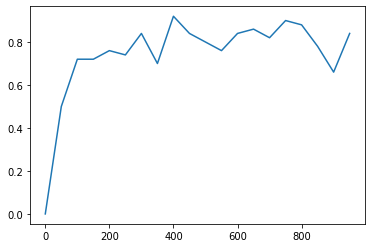

In [75]:
mc.show_reward().plot()

In [66]:
# 初めは経験が少ないのでランダムに動くため、報酬が少ないが次第に高い報酬が見込まれる行動をとれるようになる

0.5106862726566489